In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=dd9458445babd9749bba37da42118473e7461b32037d118e8ea6383ff357a59b
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark=SparkSession.builder.appName("recommend").getOrCreate()

In [4]:
ratings=spark.read.csv('/content/drive/MyDrive/movielensdataset/ratings.csv',
                       header=True,inferSchema=True)

In [5]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



In [7]:
ratings.groupBy('rating').count().show()

+------+-------+
|rating|  count|
+------+-------+
|   3.5|3116213|
|   4.5|2170441|
|   2.5|1255358|
|   1.0| 843310|
|   4.0|6998802|
|   0.5| 404897|
|   3.0|5256722|
|   2.0|1762440|
|   1.5| 403607|
|   5.0|3812499|
+------+-------+



In [9]:
# Collaborative Filtering - Alternative Least Squares (ALS) algorithm
# Alternating Least Square (ALS) is also a matrix factorization algorithm and
# it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML
# and built for a larges-scale collaborative filtering problems.

# ALS minimizes two loss functions alternatively;
# It first holds user matrix fixed and runs gradient descent with item matrix;
# then it holds item matrix fixed and runs gradient descent with user matrix

# Below is Matrix Factorization

# Hyper parameter tuning for ALS Algorithm
# numBlocks - blocks to be used for parallel Computation
# rank - number of latent factors in model
# iterations - number of iterations to run
# lambda - regularization parameter (defalut L2 - Ridge Regression)
# implicitPrefs - whether to use Explicit Feedback ALS or Implicit Feedback Als
# alpha - implicit feedback variant

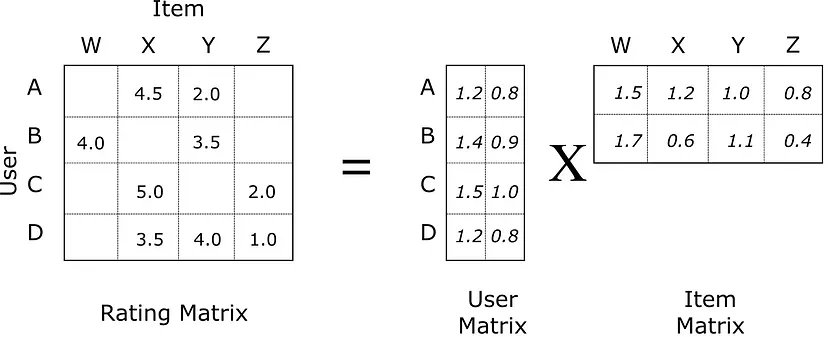

In [10]:
from pyspark.ml.recommendation import ALS

In [11]:
als=ALS(maxIter=5,regParam=0.01,userCol='userId',itemCol='movieId',
        ratingCol='rating')

In [12]:
almodel=als.fit(ratings)

In [13]:
ratings_predict=almodel.transform(ratings)

In [14]:
ratings_predict.show(5)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    858|   5.0|1425941523| 4.3291545|
|     1|   1968|   4.0|1425942148| 4.0975027|
|     1|   1221|   5.0|1425941546|   4.27117|
|     1|    110|   1.0|1425941529| 2.6400564|
|     1|    147|   4.5|1425942435|  4.683666|
+------+-------+------+----------+----------+
only showing top 5 rows



In [15]:
from pyspark.ml.evaluation import RegressionEvaluator

In [18]:
evaluator=RegressionEvaluator(metricName='rmse',labelCol='rating')

In [19]:
evaluator.evaluate(ratings_predict)

0.7382349273927417

In [21]:
# predict on single user
userId10=ratings.filter(ratings['userId']==10).select(['movieId','userId',
                                                       'rating'])

In [22]:
userId10.show()

+-------+------+------+
|movieId|userId|rating|
+-------+------+------+
|    150|    10|   4.0|
|    153|    10|   3.0|
|    165|    10|   4.0|
|    296|    10|   5.0|
|    344|    10|   4.0|
|    349|    10|   5.0|
|    380|    10|   5.0|
|    457|    10|   4.0|
|    588|    10|   5.0|
|    590|    10|   3.0|
|    592|    10|   4.0|
|    593|    10|   4.0|
|    595|    10|   5.0|
+-------+------+------+



In [23]:
userid10_recommend=almodel.transform(userId10)

In [24]:
userid10_recommend.orderBy('prediction',ascending=False).show()

+-------+------+------+----------+
|movieId|userId|rating|prediction|
+-------+------+------+----------+
|    588|    10|   5.0| 4.5520754|
|    592|    10|   4.0|  4.501298|
|    595|    10|   5.0|  4.488222|
|    457|    10|   4.0|  4.411811|
|    380|    10|   5.0| 4.3345966|
|    296|    10|   5.0|  4.333402|
|    150|    10|   4.0| 4.3093014|
|    165|    10|   4.0| 4.0798903|
|    344|    10|   4.0|  4.017624|
|    593|    10|   4.0| 3.9406488|
|    349|    10|   5.0| 3.9130826|
|    590|    10|   3.0|  3.514904|
|    153|    10|   3.0| 3.1185188|
+-------+------+------+----------+



In [25]:
(rating_train,rating_test)=ratings.randomSplit([0.75,0.25],seed=42)

In [26]:
alstrain=als.fit(rating_train)

In [27]:
als_test=alstrain.transform(rating_test)

In [28]:
als_test.show(5)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    858|   5.0|1425941523|  4.470038|
|     1|   2762|   4.5|1425941300| 4.1516347|
|     1|   2959|   4.0|1425941601| 4.5515785|
|     1|   4226|   4.0|1425942228| 4.9523673|
|     1|  54503|   3.5|1425941313|  4.219918|
+------+-------+------+----------+----------+
only showing top 5 rows

